In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image as pil_image
import os
import matplotlib.pyplot as plt
from copy import deepcopy

# Original image

In [46]:
train_img = []
IMG_HEIGHT =512
IMG_WIDTH =512
for img_folder in os.listdir('train_img/'):
    for img_jpg in os.listdir('train_img/'+img_folder):
        img = pil_image.open('train_img/'+img_folder+'/'+img_jpg)
        img = img.resize((IMG_HEIGHT,IMG_WIDTH))
        img = np.array(img)
        #img = img.astype('float32')
        train_img.append(img)


In [56]:
train_img[4].shape

(256, 256, 3)

In [36]:
img = pil_image.open('train_img/81304/000031772.jpg')
img=img.resize((512,512))
img = np.array(img)
img=img/255
img.shape

(512, 512, 3)

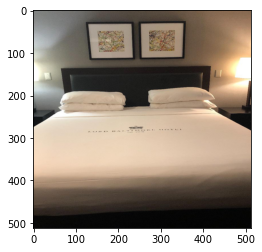

In [40]:
plt.imshow(img)

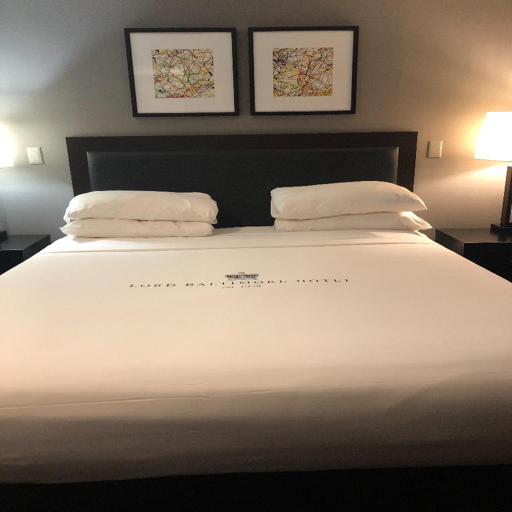

In [44]:
resizeimg =pil_image.fromarray((img*255).astype(np.uint8))
resizeimg

# Mask image

In [2]:
train_masks = []
IMG_HEIGHT =256
IMG_WIDTH =256
#count = 0
for mask in os.listdir('train_masks'):
    img = np.array(pil_image.open('train_masks/'+mask))
    #img = np.resize(img,(IMG_HEIGHT,IMG_WIDTH,3))
    #img = img.astype('float32')
    train_masks.append(img)



In [160]:
imgm = pil_image.open('train_masks/00006.png')
#imgm = imgm.convert('RGB')
imgm = imgm.resize((512,512))
imgm = np.array(imgm)
#imgm = imgm[:,:,:3]
imgm.shape


(512, 512, 4)

In [161]:
imgm=imgm/255
mask = imgm[:, :, 3] == 1

In [162]:
mask.shape

(512, 512)

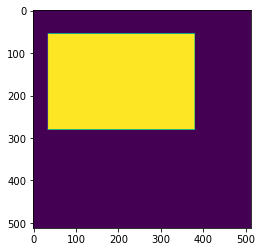

In [164]:
plt.imshow(mask)

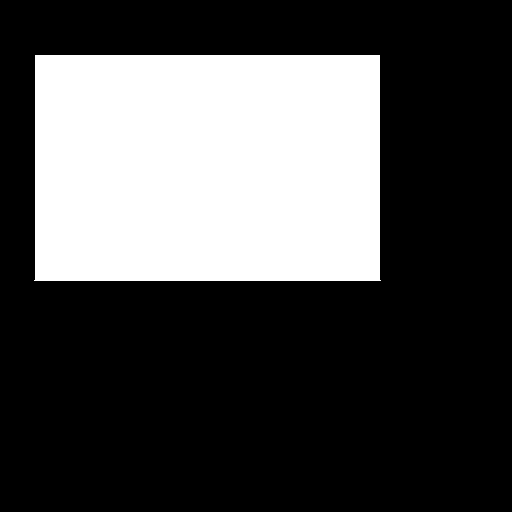

In [169]:
pil_image.fromarray((mask*255).astype(np.uint8))

In [170]:
np.unique(mask,return_counts=True)


(array([False,  True]), array([184172,  77972]))

# combine: img+ mask = MASKED_image

In [144]:
masked_img = deepcopy(img)
masked_img[mask] = 0

In [113]:
np.unique(masked_img,return_counts=True)

(array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
        0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
        0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
        0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
        0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
        0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
        0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
        0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
        0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
        0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
        0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
        0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25098039,
        0.25490196, 0.25882353, 0.2627451 , 0.26666667, 0.27058824,
        0.2745098 , 0.27843137, 0.28235294, 0.28

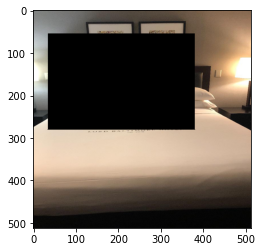

In [145]:
plt.imshow(masked_img)

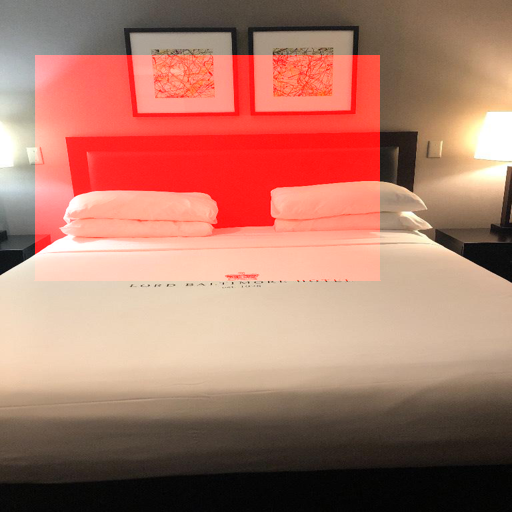

In [132]:
pil_image.fromarray((masked_img*255).astype(np.uint8))

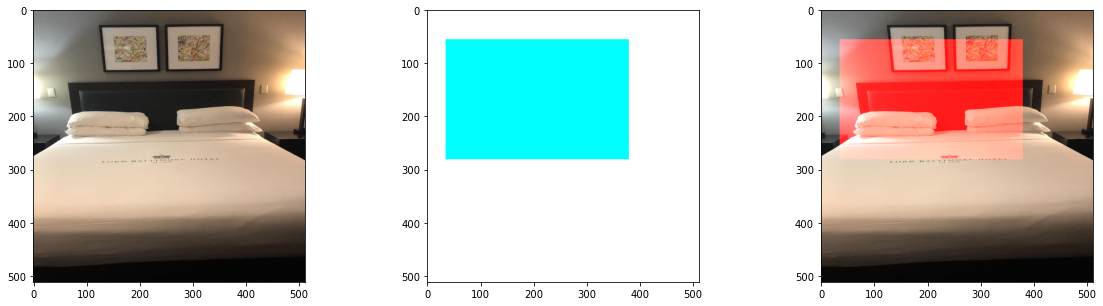

In [54]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(img_msk*255)
axes[2].imshow(masked_img)
plt.show()

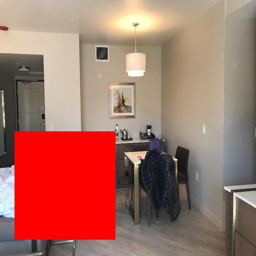

In [49]:
im = pil_image.open('test_img/abc.jpg')
imz= im.resize((256,256))
imz


(256, 256, 3)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 17

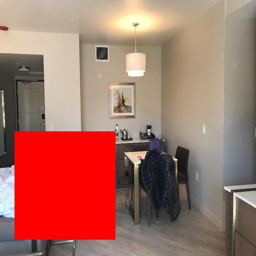

In [54]:
arim = np.array(imz)
print(arim.shape)
arim = np.where(arim==0,0,arim)
print(np.unique(arim, return_counts=True))
ier= pil_image.fromarray(arim)
ier

# #model

In [102]:
from pconv_layer import PConv2D
shape=(512,512,3)
# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

2022-04-29 16:56:22.767499: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 16:56:22.769119: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 8) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 8, 16) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 16, 32) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 32, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (Non

In [109]:
from libs.pconv_model import PConvUnet

In [111]:
PConvUnet().summary()

tracking <tf.Variable 'p_conv2d_41/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_42/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_43/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_44/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_45/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_46/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_47/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_48/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_49/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_50/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

In [115]:
model = PConvUnet()

tracking <tf.Variable 'p_conv2d_73/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_74/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_75/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_76/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_77/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_78/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_79/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_80/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_81/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_82/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

In [121]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_73 (PConv2D)           [(None, 256, 256, 64 18880       inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 256, 256, 64) 0           p_conv2d_73[0][0]         

In [ ]:
generator =[[,imgmsk],img] 

In [122]:
model.fit_generator(
    generator, 
    steps_per_epoch=2000,
    epochs=10,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)

NameError: name 'generator' is not defined